In [1]:
import os
from langchain.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain.chains import create_extraction_chain
from typing import Optional, List
from langchain.chains import create_extraction_chain_pydantic
from langchain_core.pydantic_v1 import BaseModel
from langchain import hub
from langchain.docstore.document import Document
from cerebras.cloud.sdk import Cerebras
from langsmith import Client
import json
from langchain.docstore.document import Document
from dotenv import load_dotenv
from rich import print
from langchain.docstore.document import Document
from langchain_community.chat_models import ChatOllama
from langchain_community.vectorstores import Chroma
from langchain_community import embeddings
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
import torch

# Load environment variables
load_dotenv()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

/home/tahlilmahfuz/thesis/RAG_Implementation/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3670: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


Using device: cuda

In [2]:
# Initialize Cerebras client
cerebras_api_key = os.getenv("CEREBRAS_API_KEY")
if not cerebras_api_key:
    raise ValueError("CEREBRAS_API_KEY not found in environment variables")

client = Cerebras(api_key=cerebras_api_key)
model = "llama-4-scout-17b-16e-instruct"

# Function to invoke Cerebras API
def cerebras_invoke(prompt: str) -> str:
    try:
        response = client.chat.completions.create(
            messages=[{"role": "user", "content": prompt}],
            model=model,
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"[Error] Cerebras API invocation failed: {e}")
        return ""

In [3]:
# Pull the proposal-indexing prompt from the hub
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
obj = Client(api_key=LANGSMITH_API_KEY).pull_prompt("wfh/proposal-indexing", include_model=True)

In [4]:
class Sentences(BaseModel):
    sentences: List[str]

def get_propositions(text, prompt):
    formatted_prompt = prompt.format(input=text) + "\n\nOnly provide the list of propositions as output. Do not include any explanations, formatting, or additional text."
    # print(f"Formatted Prompt: {formatted_prompt}")
    response = cerebras_invoke(formatted_prompt)
    # print(f"Response: {response}")
    propositions = response.split('\n')
    return {"proposition": [Sentences(sentences=propositions)]}, response


In [5]:
# Load JSON data
with open("islamic_etiquette_knowledge_base.json", "r") as f1, open("Quran_app_Documentation.json", "r") as f2:
    etiquette_data = json.load(f1)
    quran_app_data = json.load(f2)

# Use only Quran app data as per the query
combined_documents = quran_app_data[:3]

# List to hold all proposition arrays with metadata
proposition_arrays = []

# Process each JSON object
for json_obj in combined_documents:
    text = json_obj['text']
    propositions, response = get_propositions(text, obj)
    
    # Create an array entry for this document's propositions
    document_propositions = {
        'metadata': {
            'url': json_obj['url'],
            'title': json_obj['title']
        },
        'propositions': [
            prop for prop in propositions['proposition'][0].sentences if prop.strip()
        ]
    }
    proposition_arrays.append(document_propositions)

# If you need a flat list of all propositions with their metadata:
flat_propositions_with_metadata = []
for doc in proposition_arrays:
    for prop in doc['propositions']:
        flat_propositions_with_metadata.append({
            'proposition': prop,
            'metadata': doc['metadata']
        })

# And if you just need a simple list of all propositions:
propositions_list = [prop for doc in proposition_arrays for prop in doc['propositions']]

In [6]:
print(len(propositions_list))

83

In [7]:
import os
import json
import uuid
import numpy as np
import torch
import faiss
from dotenv import load_dotenv
from typing import Optional
from rich import print
from sentence_transformers import SentenceTransformer, CrossEncoder
from rank_bm25 import BM25Okapi
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document
from cerebras.cloud.sdk import Cerebras

load_dotenv()
class AgenticChunker:
    def __init__(self, cerebras_api_key: Optional[str] = None):
        self.chunks = {}
        self.id_truncate_limit = 5
        self.generate_new_metadata_ind = True
        self.print_logging = True

        if cerebras_api_key is None:
            cerebras_api_key = os.getenv("CEREBRAS_API_KEY")
        if cerebras_api_key is None:
            raise ValueError("CEREBRAS_API_KEY not provided or found in environment variables")

        self.client = Cerebras(api_key=cerebras_api_key)
        self.model = "llama-4-scout-17b-16e-instruct"

    def _llm_invoke(self, prompt: str) -> str:
        try:
            response = self.client.chat.completions.create(
                messages=[{"role": "user", "content": prompt}],
                model=self.model,
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            print(f"[Error] LLM invocation failed: {e}")
            return ""

    def add_propositions(self, propositions: list):
        for proposition in propositions:
            self.add_proposition(proposition)

    def add_proposition(self, proposition: str):
        if self.print_logging:
            print(f"\nAdding: '{proposition}'")
        if len(self.chunks) == 0:
            if self.print_logging:
                print("No chunks, creating a new one")
            self._create_new_chunk(proposition)
            return

        chunk_id = self._find_relevant_chunk(proposition)
        if chunk_id:
            if self.print_logging:
                print(f"Chunk Found ({self.chunks[chunk_id]['chunk_id']}), adding to: {self.chunks[chunk_id]['title']}")
            self.add_proposition_to_chunk(chunk_id, proposition)
        else:
            if self.print_logging:
                print("No chunks found")
            self._create_new_chunk(proposition)

    def add_proposition_to_chunk(self, chunk_id: str, proposition: str):
        self.chunks[chunk_id]['propositions'].append(proposition)
        if self.generate_new_metadata_ind:
            self.chunks[chunk_id]['summary'] = self._update_chunk_summary(self.chunks[chunk_id])
            self.chunks[chunk_id]['title'] = self._update_chunk_title(self.chunks[chunk_id])

    def _update_chunk_summary(self, chunk: dict) -> str:
        prompt = (
            "You are the steward of a group of chunks which represent groups of sentences that talk about a similar topic.\n"
            "A new proposition was just added to one of your chunks. Generate a very brief 1-sentence summary which will inform viewers what a chunk group is about.\n"
            "A good summary will say what the chunk is about, and give any clarifying instructions on what to add to the chunk.\n"
            "Your summaries should anticipate generalization. If you get a proposition about apples, generalize it to food. Or month, generalize it to 'date and times'.\n"
            "Example:\n"
            "Input: Proposition: Greg likes to eat pizza\n"
            "Output: This chunk contains information about the types of food Greg likes to eat.\n"
            "Only respond with the chunk new summary, nothing else.\n"
            f"Chunk's propositions:\n" + "\n".join(chunk['propositions']) +
            f"\n\nCurrent chunk summary:\n{chunk['summary']}"
        )
        return self._llm_invoke(prompt)

    def _update_chunk_title(self, chunk: dict) -> str:
        prompt = (
            "You are the steward of a group of chunks which represent groups of sentences that talk about a similar topic.\n"
            "A new proposition was just added to one of your chunks, you should generate a very brief updated chunk title which will inform viewers what a chunk group is about.\n"
            "A good title will say what the chunk is about.\n"
            "You will be given a group of propositions which are in the chunk, chunk summary and the chunk title.\n"
            "Your title should anticipate generalization. If you get a proposition about apples, generalize it to food. Or month, generalize it to \"date and times\".\n"
            "Example:\n"
            "Input: Summary: This chunk is about dates and times that the author talks about\n"
            "Output: Date & Times\n"
            "Only respond with the new chunk title, nothing else.\n"
            f"Chunk's propositions:\n" + "\n".join(chunk['propositions']) +
            f"\n\nChunk summary:\n{chunk['summary']}\n\nCurrent chunk title:\n{chunk['title']}"
        )
        return self._llm_invoke(prompt)

    def _get_new_chunk_summary(self, proposition: str) -> str:
        prompt = (
            "You are the steward of a group of chunks which represent groups of sentences that talk about a similar topic.\n"
            "You should generate a very brief 1-sentence summary which will inform viewers what a chunk group is about.\n"
            "A good summary will say what the chunk is about, and give any clarifying instructions on what to add to the chunk.\n"
            "You will be given a proposition which will go into a new chunk. This new chunk needs a summary.\n"
            "Your summaries should anticipate generalization. If you get a proposition about apples, generalize it to food. Or month, generalize it to \"date and times\".\n"
            "Example:\n"
            "Input: Proposition: Greg likes to eat pizza\n"
            "Output: This chunk contains information about the types of food Greg likes to eat.\n"
            "Only respond with the new chunk summary, nothing else.\n"
            f"Determine the summary of the new chunk that this proposition will go into:\n{proposition}"
        )
        return self._llm_invoke(prompt)

    def _get_new_chunk_title(self, summary: str) -> str:
        prompt = (
            "You are the steward of a group of chunks which represent groups of sentences that talk about a similar topic.\n"
            "You should generate a very brief few word chunk title which will inform viewers what a chunk group is about.\n"
            "A good chunk title is brief but encompasses what the chunk is about.\n"
            "You will be given a summary of a chunk which needs a title.\n"
            "Your titles should anticipate generalization. If you get a proposition about apples, generalize it to food. Or month, generalize it to \"date and times\".\n"
            "Example:\n"
            "Input: Summary: This chunk is about dates and times that the author talks about\n"
            "Output: Date & Times\n"
            "Only respond with the new chunk title, nothing else.\n"
            f"Determine the title of the chunk that this summary belongs to:\n{summary}"
        )
        return self._llm_invoke(prompt)

    def _create_new_chunk(self, proposition: str):
        new_chunk_id = str(uuid.uuid4())[:self.id_truncate_limit]
        new_chunk_summary = self._get_new_chunk_summary(proposition)
        new_chunk_title = self._get_new_chunk_title(new_chunk_summary)
        self.chunks[new_chunk_id] = {
            'chunk_id': new_chunk_id,
            'propositions': [proposition],
            'title': new_chunk_title,
            'summary': new_chunk_summary,
            'chunk_index': len(self.chunks)
        }
        if self.print_logging:
            print(f"Created new chunk ({new_chunk_id}): {new_chunk_title}")

    def get_chunk_outline(self) -> str:
        chunk_outline = ""
        for chunk_id, chunk in self.chunks.items():
            single_chunk_string = f"""Chunk ({chunk['chunk_id']}): {chunk['title']}\nSummary: {chunk['summary']}\n\n"""
            chunk_outline += single_chunk_string
        return chunk_outline

    def _find_relevant_chunk(self, proposition: str) -> Optional[str]:
        current_chunk_outline = self.get_chunk_outline()
        prompt = (
            "Determine whether or not the 'Proposition' should belong to any of the existing chunks.\n"
            "A proposition should belong to a chunk if their meaning, direction, or intention are similar.\n"
            "The goal is to group similar propositions and chunks.\n"
            "If you think a proposition should be joined with a chunk, return the chunk id.\n"
            "If you do not think an item should be joined with an existing chunk, just return 'No chunks'.\n"
            "Example:\n"
            "Input:\n"
            "    - Proposition: 'Greg really likes hamburgers'\n"
            "    - Current Chunks:\n"
            "        - Chunk ID: 2n4l3d\n"
            "        - Chunk Name: Places in San Francisco\n"
            "        - Chunk Summary: Overview of the things to do with San Francisco Places\n"
            "        - Chunk ID: 93833k\n"
            "        - Chunk Name: Food Greg likes\n"
            "        - Chunk Summary: Lists of the food and dishes that Greg likes\n"
            "Output: 93833k\n"
            f"Current Chunks:\n--Start of current chunks--\n{current_chunk_outline}\n--End of current chunks--\n"
            f"Determine if the following statement should belong to one of the chunks outlined:\n{proposition}"
            f"Do not write anything else. Only return the chunk id if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.\n"
        )
        print(f"\n[DEBUG] LLM Prompt:\n{prompt}\n")
        chunk_found = self._llm_invoke(prompt).strip()
        print(f"[DEBUG] Chunk Found: {chunk_found}")
        if len(chunk_found) == self.id_truncate_limit and chunk_found in self.chunks:
            return chunk_found
        return None

    def get_chunks(self, get_type: str = 'dict') -> list:
        if get_type == 'dict':
            return self.chunks
        if get_type == 'list_of_strings':
            return [" ".join(chunk['propositions']) for chunk in self.chunks.values()]

    def pretty_print_chunks(self):
        print(f"\nYou have {len(self.chunks)} chunks\n")
        for chunk_id, chunk in self.chunks.items():
            print(f"Chunk #{chunk['chunk_index']}")
            print(f"Chunk ID: {chunk_id}")
            print(f"Summary: {chunk['summary']}")
            print(f"Propositions:")
            for prop in chunk['propositions']:
                print(f"    - {prop}")
            print("\n")

    def pretty_print_chunk_outline(self):
        print("Chunk Outline\n")
        print(self.get_chunk_outline())

/home/tahlilmahfuz/thesis/RAG_Implementation/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Initialize AgenticChunker and add propositions
ac = AgenticChunker()
ac.add_propositions(propositions_list)

Adding: '["Audio is available to listen to the Quran.", '

No chunks, creating a new one

Created new chunk (d61e0): Religious Media Recordings

Adding: '"Listening to the Quran helps to memorise and recharge your soul.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Religious Media Recordings
Summary: This chunk contains information about audio recordings of religious texts.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Listening to the Quran helps to memorise and recharge your soul.", Do not write anything else. Only return the 
chunk id if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Religious Media Recordings

Adding: '"Recharge your soul and iman by listening to beautiful Quran recitations.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Religious Audio Content
Summary: This chunk contains information about audio recordings of religious texts.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Recharge your soul and iman by listening to beautiful Quran recitations.", Do not write anything else. Only return
the chunk id if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Religious Audio Content

Adding: '"Over 50 renowned reciters are available.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Religious Audio Content
Summary: This chunk contains information about audio recordings of religious texts, particularly those related to 
Islamic scripture; add propositions about listening to or utilizing recordings of sacred texts.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Over 50 renowned reciters are available.", Do not write anything else. Only return the chunk id if you think it 
should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Religious Audio Content

Adding: '"User-friendly controls are provided.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual Audio Content
Summary: This chunk contains information about audio recordings of religious texts, particularly those related to 
Islamic scripture; add propositions about listening to or utilizing recordings of sacred texts.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"User-friendly controls are provided.", Do not write anything else. Only return the chunk id if you think it should
belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: No chunks relevant to the proposition

No chunks found

Created new chunk (ea70e): Product Features

Adding: '"Audio can be downloaded for offline listening.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual Audio Content
Summary: This chunk contains information about audio recordings of religious texts, particularly those related to 
Islamic scripture; add propositions about listening to or utilizing recordings of sacred texts.

Chunk (ea70e): Product Features
Summary: This chunk contains information about the usability features of a product or system.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Audio can be downloaded for offline listening.", Do not write anything else. Only return the chunk id if you think
it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: ea70e

Chunk Found (ea70e), adding to: Product Features

Adding: '"Audio can be streamed to save storage space.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual Audio Content
Summary: This chunk contains information about audio recordings of religious texts, particularly those related to 
Islamic scripture; add propositions about listening to or utilizing recordings of sacred texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Audio can be streamed to save storage space.", Do not write anything else. Only return the chunk id if you think 
it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: No chunks relevant to the proposition

No chunks found

Created new chunk (24ceb): Digital Storage Management

Adding: '"The repeat option assists with Quran memorization (Hifz).", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual Audio Content
Summary: This chunk contains information about audio recordings of religious texts, particularly those related to 
Islamic scripture; add propositions about listening to or utilizing recordings of sacred texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"The repeat option assists with Quran memorization (Hifz).", Do not write anything else. Only return the chunk id 
if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual Audio Content

Adding: '"Audio translations are available in English.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual Audio Content
Summary: This chunk contains information about audio recordings of religious texts, particularly those related to 
Islamic scripture; add propositions about listening to or utilizing recordings of sacred texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Audio translations are available in English.", Do not write anything else. Only return the chunk id if you think 
it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual Audio Content

Adding: '"Audio translations are available in Bangla.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual Audio Content
Summary: This chunk contains information about audio recordings of religious texts, particularly those related to 
Islamic scripture; add propositions about listening to or utilizing recordings of sacred texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Audio translations are available in Bangla.", Do not write anything else. Only return the chunk id if you think it
should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual Audio Content

Adding: '"Audio translations are available in Urdu.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Religious Audio Recordings
Summary: This chunk contains information about audio recordings of religious texts, particularly those related to 
Islamic scripture; add propositions about listening to or utilizing recordings of sacred texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Audio translations are available in Urdu.", Do not write anything else. Only return the chunk id if you think it 
should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Religious Audio Recordings

Adding: '"More translations are planned.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Sacred Text Audio Resources
Summary: This chunk contains information about audio recordings of religious texts, particularly those related to 
Islamic scripture; add propositions about listening to or utilizing recordings of sacred texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"More translations are planned.", Do not write anything else. Only return the chunk id if you think it should 
belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: No chunks relevant to the proposition

No chunks found

Created new chunk (979fb): Future Translations

Adding: '"Mishary Al Afasy is a reciter.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Sacred Text Audio Resources
Summary: This chunk contains information about audio recordings of religious texts, particularly those related to 
Islamic scripture; add propositions about listening to or utilizing recordings of sacred texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Mishary Al Afasy is a reciter.", Do not write anything else. Only return the chunk id if you think it should 
belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Sacred Text Audio Resources

Adding: '"Husary (Muallim) is a reciter.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Sacred Text Audio Resources
Summary: This chunk contains information about audio recordings of religious texts, particularly those related to 
Islamic scripture; add propositions about listening to or utilizing recordings of sacred texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Husary (Muallim) is a reciter.", Do not write anything else. Only return the chunk id if you think it should 
belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Sacred Text Audio Resources

Adding: '"Ayman Suwaid is a reciter.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Sacred Text Audio Resources
Summary: This chunk contains information about audio recordings of religious texts, particularly those related to 
Islamic scripture; add propositions about listening to or utilizing recordings of sacred texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Ayman Suwaid is a reciter.", Do not write anything else. Only return the chunk id if you think it should belong to
a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Sacred Text Audio Resources

Adding: '"Abdur Rahman As-Sudais is a reciter.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Sacred Text Audio Resources
Summary: This chunk contains information about audio recordings of Islamic scripture, specifically the Quran, and 
its recitations; add propositions about listening to, utilizing, or features of recordings of sacred texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Abdur Rahman As-Sudais is a reciter.", Do not write anything else. Only return the chunk id if you think it should
belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Sacred Text Audio Resources

Adding: '"Abdul Basit is a reciter.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Religious Scripture Audio
Summary: This chunk contains information about audio recordings of sacred texts, specifically the Quran, and its 
recitations; add propositions about listening to, utilizing, or features of recordings of religious scriptures.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Abdul Basit is a reciter.", Do not write anything else. Only return the chunk id if you think it should belong to 
a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Religious Scripture Audio

Adding: '"Minshawi is a reciter.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual Text Recordings
Summary: This chunk contains information about audio recordings of sacred texts, specifically religious scriptures 
and recitations; add propositions about listening to, utilizing, or features of recordings of spiritual texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Minshawi is a reciter.", Do not write anything else. Only return the chunk id if you think it should belong to a 
chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual Text Recordings

Adding: '"Ayman Suwaid and Husary (Muallim) can help improve recitation and tajweed.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual Text Recordings
Summary: This chunk contains information about audio recordings of sacred texts, specifically religious scriptures 
and recitations; add propositions about listening to, utilizing, or features of recordings of spiritual texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Ayman Suwaid and Husary (Muallim) can help improve recitation and tajweed.", Do not write anything else. Only 
return the chunk id if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it 
should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual Text Recordings

Adding: '"Yasser Salama Hadr has a faster recitation.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual Text Recordings
Summary: This chunk contains information about audio recordings of sacred texts, specifically religious scriptures 
and recitations; add propositions about listening to, utilizing, or features of recordings of spiritual texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Yasser Salama Hadr has a faster recitation.", Do not write anything else. Only return the chunk id if you think it
should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual Text Recordings

Adding: '"Audio translations help understand the Quran by listening.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual Text Recordings
Summary: This chunk contains information about audio recordings of sacred texts, specifically religious scriptures 
and recitations; add propositions about listening to, utilizing, or features of recordings of spiritual texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Audio translations help understand the Quran by listening.", Do not write anything else. Only return the chunk id 
if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual Text Recordings

Adding: '"Open any Surah to listen to the Quran.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual Text Recordings & Audio Features
Summary: This chunk contains information about audio recordings of sacred texts, specifically religious scriptures 
and recitations; add propositions about listening to, utilizing, or features of recordings of spiritual texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Open any Surah to listen to the Quran.", Do not write anything else. Only return the chunk id if you think it 
should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual Text Recordings & Audio Features

Adding: '"Tap the play icon below any ayah to play that ayah.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual Text Recordings & Audio Features
Summary: This chunk contains information about audio recordings of sacred texts, specifically religious scriptures 
and recitations; add propositions about listening to, utilizing, or features of recordings of spiritual texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Tap the play icon below any ayah to play that ayah.", Do not write anything else. Only return the chunk id if you 
think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual Text Recordings & Audio Features

Adding: '"Tap the play audio button at the bottom to play a range of ayahs or the entire surah.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual Text Recordings & Audio Features
Summary: This chunk contains information about audio recordings of sacred texts, specifically religious scriptures 
and recitations; add propositions about listening to, utilizing, or features of recordings of spiritual texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Tap the play audio button at the bottom to play a range of ayahs or the entire surah.", Do not write anything 
else. Only return the chunk id if you think it should belong to a chunk, or 'No chunks relevant to the proposition'
if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual Text Recordings & Audio Features

Adding: '"Choose the start and end ayah range.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual Text Recordings & Audio Features
Summary: This chunk contains information about audio recordings of sacred texts, specifically religious scriptures 
and recitations; add propositions about listening to, utilizing, or features of recordings of spiritual texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Choose the start and end ayah range.", Do not write anything else. Only return the chunk id if you think it should
belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: No chunks relevant to the proposition

No chunks found

Created new chunk (870e2): Date & Times

Adding: '"Change reciters or audio translations from the reciters list.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual Text Recordings & Audio Features
Summary: This chunk contains information about audio recordings of sacred texts, specifically religious scriptures 
and recitations; add propositions about listening to, utilizing, or features of recordings of spiritual texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Change reciters or audio translations from the reciters list.", Do not write anything else. Only return the chunk 
id if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual Text Recordings & Audio Features

Adding: '"Use repeat options to listen to ayahs multiple times.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual Text Recordings & Audio Features
Summary: This chunk contains information about audio recordings and features of Islamic sacred texts, specifically 
the Quran and its recitations; add propositions about listening to, utilizing, or features of Quran recordings and 
related spiritual texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Use repeat options to listen to ayahs multiple times.", Do not write anything else. Only return the chunk id if 
you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual Text Recordings & Audio Features

Adding: '"Downloading audio allows for offline listening.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Islamic Sacred Text Audio Features & Recitations
Summary: This chunk contains information about audio recordings and features of Islamic sacred texts, specifically 
the Quran and its recitations; add propositions about listening to, utilizing, or features of Quran recordings and 
related spiritual texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Downloading audio allows for offline listening.", Do not write anything else. Only return the chunk id if you 
think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Islamic Sacred Text Audio Features & Recitations

Adding: '"Streaming audio saves storage space.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Religious Audio Features & Recitations
Summary: This chunk contains information about audio recordings and features of Islamic sacred texts, specifically 
the Quran and its recitations; add propositions about listening to, utilizing, or features of Quran recordings and 
related spiritual texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Management
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Streaming audio saves storage space.", Do not write anything else. Only return the chunk id if you think it should
belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: 24ceb

Chunk Found (24ceb), adding to: Digital Storage Management

Adding: '"Playback speed can be adjusted.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Religious Audio Features & Recitations
Summary: This chunk contains information about audio recordings and features of Islamic sacred texts, specifically 
the Quran and its recitations; add propositions about listening to, utilizing, or features of Quran recordings and 
related spiritual texts.

Chunk (ea70e): Accessibility Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Playback speed can be adjusted.", Do not write anything else. Only return the chunk id if you think it should 
belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: ea70e

Chunk Found (ea70e), adding to: Accessibility Features

Adding: '"Single recitation mode is ideal for most users.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Religious Audio Features & Recitations
Summary: This chunk contains information about audio recordings and features of Islamic sacred texts, specifically 
the Quran and its recitations; add propositions about listening to, utilizing, or features of Quran recordings and 
related spiritual texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Single recitation mode is ideal for most users.", Do not write anything else. Only return the chunk id if you 
think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Religious Audio Features & Recitations

Adding: '"Multiple recitation mode allows selecting up to 3 reciters.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Audio Content
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Multiple recitation mode allows selecting up to 3 reciters.", Do not write anything else. Only return the chunk id
if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual & Religious Audio Content

Adding: '"The Al Quran (Tafsir & by Word) app is available."]'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Audio Content
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"The Al Quran (Tafsir & by Word) app is available."]Do not write anything else. Only return the chunk id if you 
think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual & Religious Audio Content

Adding: '["The Al Quran (Tafsir & by Word) app has a search function.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Audio Content
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
["The Al Quran (Tafsir & by Word) app has a search function.", Do not write anything else. Only return the chunk id
if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: ea70e

Chunk Found (ea70e), adding to: Usability Features

Adding: '"The search function allows users to find a specific ayah or topic in the Quran.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Audio Content
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"The search function allows users to find a specific ayah or topic in the Quran.", Do not write anything else. Only
return the chunk id if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it 
should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual & Religious Audio Content

Adding: '"The app is called Al Quran (Tafsir & by Word).", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Audio Content
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"The app is called Al Quran (Tafsir & by Word).", Do not write anything else. Only return the chunk id if you think
it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual & Religious Audio Content

Adding: '"Users can search through surah names, Arabic ayahs, translations, and tafsirs all in one place.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Audio Content
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Users can search through surah names, Arabic ayahs, translations, and tafsirs all in one place.", Do not write 
anything else. Only return the chunk id if you think it should belong to a chunk, or 'No chunks relevant to the 
proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual & Religious Audio Content

Adding: '"There is a feature for quick surah access.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Religious Texts & Audio Features
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"There is a feature for quick surah access.", Do not write anything else. Only return the chunk id if you think it 
should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Religious Texts & Audio Features

Adding: '"Typing a surah name opens it instantly.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Religious Texts & Audio Features
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Typing a surah name opens it instantly.", Do not write anything else. Only return the chunk id if you think it 
should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Religious Texts & Audio Features

Adding: '"The search function understands minor spelling variations.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual Texts & Audio Features
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"The search function understands minor spelling variations.", Do not write anything else. Only return the chunk id 
if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: ea70e

Chunk Found (ea70e), adding to: Usability Features

Adding: '"Users can jump to a specific ayah using simple notation.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual Texts & Audio Features
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Users can jump to a specific ayah using simple notation.", Do not write anything else. Only return the chunk id if
you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual Texts & Audio Features

Adding: '"Notation format for ayah is 'surah:ayah'.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Religious Texts & Audio Features
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Notation format for ayah is 'surah:ayah'.", Do not write anything else. Only return the chunk id if you think it 
should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Religious Texts & Audio Features

Adding: '"Example of notation format is '2:255'.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Audio Resources
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Example of notation format is '2:255'.", Do not write anything else. Only return the chunk id if you think it 
should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: No chunks relevant to the proposition

No chunks found

Created new chunk (a2685): Data Formats

Adding: '"Users can search translations and tafsirs.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Audio Resources
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Future Translations
Summary: This chunk contains information about future plans for translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Users can search translations and tafsirs.", Do not write anything else. Only return the chunk id if you think it 
should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: 979fb

Chunk Found (979fb), adding to: Future Translations

Adding: '"Users can filter results by specific translations or tafsirs.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Audio Resources
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about future plans and features for translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Users can filter results by specific translations or tafsirs.", Do not write anything else. Only return the chunk 
id if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: 979fb

Chunk Found (979fb), adding to: Translation Features & Plans

Adding: '"There is a feature to explore Quranic topics.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Audio Resources
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"There is a feature to explore Quranic topics.", Do not write anything else. Only return the chunk id if you think 
it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual & Religious Audio Resources

Adding: '"Quranic topics are organized.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Audio Resources
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Quranic topics are organized.", Do not write anything else. Only return the chunk id if you think it should belong
to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual & Religious Audio Resources

Adding: '"Users can find ayahs related to specific themes and teachings.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Audio Resources
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Users can find ayahs related to specific themes and teachings.", Do not write anything else. Only return the chunk
id if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual & Religious Audio Resources

Adding: '"There is an option to access Quranic topics in the menu drawer.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Religious Audio & Recitations
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"There is an option to access Quranic topics in the menu drawer.", Do not write anything else. Only return the 
chunk id if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Religious Audio & Recitations

Adding: '"There is a word analysis search feature.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"There is a word analysis search feature.", Do not write anything else. Only return the chunk id if you think it 
should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: ea70e

Chunk Found (ea70e), adding to: Usability Features

Adding: '"Users can see occurrences of Arabic words, lemma, and roots across the Quran.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Users can see occurrences of Arabic words, lemma, and roots across the Quran.", Do not write anything else. Only 
return the chunk id if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it 
should not.

[DEBUG] Chunk Found: d61e0

Chunk Found (d61e0), adding to: Spiritual & Religious Texts & Audio

Adding: '"To see word/root/lemma occurrences, users must first tap on a word.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"To see word/root/lemma occurrences, users must first tap on a word.", Do not write anything else. Only return the 
chunk id if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: ea70e

Chunk Found (ea70e), adding to: Usability Features

Adding: '"Voice search is available on Android experimentally.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Voice search is available on Android experimentally.", Do not write anything else. Only return the chunk id if you
think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: No chunks relevant to the proposition

No chunks found

Created new chunk (09bb5): Voice Search Availability

Adding: '"Voice search has bugs in Arabic search.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Voice Search Availability
Summary: This chunk contains information about the availability of voice search on different devices or platforms.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Voice search has bugs in Arabic search.", Do not write anything else. Only return the chunk id if you think it 
should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: 09bb5

Chunk Found (09bb5), adding to: Voice Search Availability

Adding: '"The bugs in Arabic search will be improved in the coming months.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability and functionality of voice search on different 
devices or platforms.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"The bugs in Arabic search will be improved in the coming months.", Do not write anything else. Only return the 
chunk id if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: 09bb5

Chunk Found (09bb5), adding to: Search Functionality & Availability

Adding: '"The app is available on Android.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"The app is available on Android.", Do not write anything else. Only return the chunk id if you think it should 
belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: No chunks

No chunks found

Created new chunk (7ec23): App Platforms

Adding: '"The guide is concluded.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"The guide is concluded.", Do not write anything else. Only return the chunk id if you think it should belong to a 
chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: No chunks relevant to the proposition

No chunks found

Created new chunk (e7a69): Guide Outcomes

Adding: '"Users are encouraged to start searching in the Al Quran (Tafsir & by Word) app.", '

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Users are encouraged to start searching in the Al Quran (Tafsir & by Word) app.", Do not write anything else. Only
return the chunk id if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it 
should not.

[DEBUG] Chunk Found: No chunks relevant to the proposition

No chunks found

Created new chunk (d5963): Religious Study Resources

Adding: '"Users are encouraged to provide feedback."]'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials.

Chunk (d5963): Religious Study Resources
Summary: This chunk contains information about recommended resources or tools for searching or studying religious 
texts.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
"Users are encouraged to provide feedback."]Do not write anything else. Only return the chunk id if you think it 
should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: No chunks relevant to the proposition

No chunks found

Created new chunk (d13ba): User Interaction

Adding: '['

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials.

Chunk (d5963): Religious Study Resources
Summary: This chunk contains information about recommended resources or tools for searching or studying religious 
texts.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
[Do not write anything else. Only return the chunk id if you think it should belong to a chunk, or 'No chunks 
relevant to the proposition' if it should not.

[DEBUG] Chunk Found: No chunks relevant to the proposition

No chunks found

Created new chunk (b47ec): No proposition provided.

Adding: '  "The Quran Planner helps users break down their reading into manageable daily sessions.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials.

Chunk (d5963): Religious Study Resources
Summary: This chunk contains information about recommended resources or tools for searching or studying religious 
texts.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "The Quran Planner helps users break down their reading into manageable daily sessions.",Do not write anything 
else. Only return the chunk id if you think it should belong to a chunk, or 'No chunks relevant to the proposition'
if it should not.

[DEBUG] Chunk Found: d5963

Chunk Found (d5963), adding to: Religious Study Resources

Adding: '  "The Quran Planner keeps users organized and motivated to reach their goal.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials.

Chunk (d5963): Religious Study Resources & Tools
Summary: This chunk contains information about recommended resources or tools for searching or studying religious 
texts.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "The Quran Planner keeps users organized and motivated to reach their goal.",Do not write anything else. Only 
return the chunk id if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it 
should not.

[DEBUG] Chunk Found: d5963

Chunk Found (d5963), adding to: Religious Study Resources & Tools

Adding: '  "Users can read the Quran in 29 days.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials.

Chunk (d5963): Religious Study Resources & Tools
Summary: This chunk contains information about recommended resources or tools for searching or studying religious 
texts, specifically the Quran, or tools that help with planning and organization of studying religious texts.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "Users can read the Quran in 29 days.",Do not write anything else. Only return the chunk id if you think it 
should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d5963

Chunk Found (d5963), adding to: Religious Study Resources & Tools

Adding: '  "Reading the Quran in 29 days is ideal for Ramadan.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials.

Chunk (d5963): Religious Study Resources & Tools
Summary: This chunk contains information about recommended resources or tools for searching, studying, or planning 
the reading of religious texts.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "Reading the Quran in 29 days is ideal for Ramadan.",Do not write anything else. Only return the chunk id if you 
think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d5963

Chunk Found (d5963), adding to: Religious Study Resources & Tools

Adding: '  "Users can complete the Quran in one year.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials.

Chunk (d5963): Religious Study Resources & Tools
Summary: This chunk contains information about recommended resources or tools for searching, studying, or planning 
the reading of religious texts, specifically the Quran, and tips for reading it within a certain timeframe.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "Users can complete the Quran in one year.",Do not write anything else. Only return the chunk id if you think it 
should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d5963

Chunk Found (d5963), adding to: Religious Study Resources & Tools

Adding: '  "Completing the Quran in one year requires reading about 2 pages daily.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials.

Chunk (d5963): Religious Study Resources & Tools
Summary: This chunk contains information about recommended resources or tools for searching, studying, or planning 
the reading of religious texts, and tips for reading them within a certain timeframe.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "Completing the Quran in one year requires reading about 2 pages daily.",Do not write anything else. Only return 
the chunk id if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d5963

Chunk Found (d5963), adding to: Religious Study Resources & Tools

Adding: '  "Users can read the Quran translation in 90 days.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials.

Chunk (d5963): Reading Plans & Resources
Summary: This chunk contains information about planning and managing the reading of religious texts, including 
recommended timeframes and resources to help users stay organized and motivated.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "Users can read the Quran translation in 90 days.",Do not write anything else. Only return the chunk id if you 
think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d5963

Chunk Found (d5963), adding to: Reading Plans & Resources

Adding: '  "Reading the Quran translation in 90 days improves understanding.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials.

Chunk (d5963): Reading Plans & Resources
Summary: This chunk contains information about planning and managing the reading of religious texts, including 
recommended timeframes and resources to help users stay organized and motivated.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "Reading the Quran translation in 90 days improves understanding.",Do not write anything else. Only return the 
chunk id if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d5963

Chunk Found (d5963), adding to: Reading Plans & Resources

Adding: '  "Users can create their own custom schedule.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials.

Chunk (d5963): Reading Plans & Resources
Summary: This chunk contains information about planning and managing the reading of religious texts, including 
recommended timeframes and resources to help users stay organized and motivated.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "Users can create their own custom schedule.",Do not write anything else. Only return the chunk id if you think 
it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: No chunks relevant to the proposition

No chunks found

Created new chunk (2e345): Scheduling Options

Adding: '  "To start using the Quran Planner, users create a plan.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials.

Chunk (d5963): Reading Plans & Resources
Summary: This chunk contains information about planning and managing the reading of religious texts, including 
recommended timeframes and resources to help users stay organized and motivated.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.

Chunk (2e345): Scheduling Options
Summary: This chunk contains information about the scheduling options available to users.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "To start using the Quran Planner, users create a plan.",Do not write anything else. Only return the chunk id if 
you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d5963

Chunk Found (d5963), adding to: Reading Plans & Resources

Adding: '  "To create a plan, users select a start and end range.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials.

Chunk (d5963): Reading Plans & Resources
Summary: This chunk contains information about planning and managing the reading of religious texts, including 
recommended timeframes and resources to help users stay organized and motivated.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.

Chunk (2e345): Scheduling Options
Summary: This chunk contains information about the scheduling options available to users.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "To create a plan, users select a start and end range.",Do not write anything else. Only return the chunk id if 
you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: 870e2

Chunk Found (870e2), adding to: Date & Times

Adding: '  "To create a plan, users set the number of days.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials.

Chunk (d5963): Reading Plans & Resources
Summary: This chunk contains information about planning and managing the reading of religious texts, including 
recommended timeframes and resources to help users stay organized and motivated.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.

Chunk (2e345): Scheduling Options
Summary: This chunk contains information about the scheduling options available to users.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "To create a plan, users set the number of days.",Do not write anything else. Only return the chunk id if you 
think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: 870e2

Chunk Found (870e2), adding to: Date & Times

Adding: '  "Users should set a notification time to stay on track.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials.

Chunk (d5963): Reading Plans & Resources
Summary: This chunk contains information about planning and managing the reading of religious texts, including 
recommended timeframes and resources to help users stay organized and motivated.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.

Chunk (2e345): Scheduling Options
Summary: This chunk contains information about the scheduling options available to users.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "Users should set a notification time to stay on track.",Do not write anything else. Only return the chunk id if 
you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: 2e345

Chunk Found (2e345), adding to: Scheduling Options

Adding: '  "After creating a plan, users tap Read to begin.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials.

Chunk (d5963): Reading Plans & Resources
Summary: This chunk contains information about planning and managing the reading of religious texts, including 
recommended timeframes and resources to help users stay organized and motivated.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.

Chunk (2e345): Scheduling Options
Summary: This chunk contains information about the scheduling options available to users.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "After creating a plan, users tap Read to begin.",Do not write anything else. Only return the chunk id if you 
think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d5963

Chunk Found (d5963), adding to: Reading Plans & Resources

Adding: '  "Users read the Quran following their schedule.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials.

Chunk (d5963): Study Plans & Resources
Summary: This chunk contains information about planning and managing the reading of religious texts, including 
recommended timeframes and resources to help users stay organized and motivated.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.

Chunk (2e345): Scheduling Options
Summary: This chunk contains information about the scheduling options available to users.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "Users read the Quran following their schedule.",Do not write anything else. Only return the chunk id if you 
think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: d5963

Chunk Found (d5963), adding to: Study Plans & Resources

Adding: '  "After completing a session, users save their progress.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials.

Chunk (d5963): Reading Plans & Religious Texts
Summary: This chunk contains information about planning and managing the reading of religious texts, including 
recommended timeframes and resources to help users stay organized and motivated.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.

Chunk (2e345): Scheduling Options
Summary: This chunk contains information about the scheduling options available to users.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "After completing a session, users save their progress.",Do not write anything else. Only return the chunk id if 
you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: e7a69

Chunk Found (e7a69), adding to: Guide Outcomes

Adding: '  "Users check their planner regularly to stay on track.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes & Processes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials and 
related processes.

Chunk (d5963): Reading Plans & Religious Texts
Summary: This chunk contains information about planning and managing the reading of religious texts, including 
recommended timeframes and resources to help users stay organized and motivated.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.

Chunk (2e345): Scheduling Options
Summary: This chunk contains information about the scheduling options available to users.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "Users check their planner regularly to stay on track.",Do not write anything else. Only return the chunk id if 
you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: 2e345

Chunk Found (2e345), adding to: Scheduling Options

Adding: '  "Users celebrate completion once they finish all sessions.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes & Processes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials and 
related processes.

Chunk (d5963): Reading Plans & Religious Texts
Summary: This chunk contains information about planning and managing the reading of religious texts, including 
recommended timeframes and resources to help users stay organized and motivated.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.

Chunk (2e345): Time Management
Summary: This chunk contains information about how users manage and interact with their schedules.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "Users celebrate completion once they finish all sessions.",Do not write anything else. Only return the chunk id 
if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: e7a69

Chunk Found (e7a69), adding to: Guide Outcomes & Processes

Adding: '  "A tip for success is to start with a realistic goal.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes & Processes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials and 
related processes.

Chunk (d5963): Reading Plans & Religious Texts
Summary: This chunk contains information about planning and managing the reading of religious texts, including 
recommended timeframes and resources to help users stay organized and motivated.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.

Chunk (2e345): Time Management
Summary: This chunk contains information about how users manage and interact with their schedules.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "A tip for success is to start with a realistic goal.",Do not write anything else. Only return the chunk id if 
you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: No chunks relevant to the proposition

No chunks found

Created new chunk (fedc6): Personal Development

Adding: '  "A tip for success is to set reminders at a consistent time.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes & Processes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials and 
related processes.

Chunk (d5963): Reading Plans & Religious Texts
Summary: This chunk contains information about planning and managing the reading of religious texts, including 
recommended timeframes and resources to help users stay organized and motivated.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.

Chunk (2e345): Time Management
Summary: This chunk contains information about how users manage and interact with their schedules.

Chunk (fedc6): Personal Development
Summary: This chunk contains information and tips about achieving success.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "A tip for success is to set reminders at a consistent time.",Do not write anything else. Only return the chunk 
id if you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: fedc6

Chunk Found (fedc6), adding to: Personal Development

Adding: '  "A tip for success is to plan ahead for busy days.",'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes & Processes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials and 
related processes.

Chunk (d5963): Reading Plans & Religious Texts
Summary: This chunk contains information about planning and managing the reading of religious texts, including 
recommended timeframes and resources to help users stay organized and motivated.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.

Chunk (2e345): Time Management
Summary: This chunk contains information about how users manage and interact with their schedules.

Chunk (fedc6): Success Tips
Summary: This chunk contains information and tips about achieving success.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "A tip for success is to plan ahead for busy days.",Do not write anything else. Only return the chunk id if you 
think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: fedc6

Chunk Found (fedc6), adding to: Success Tips

Adding: '  "A tip for success is to adjust the schedule if needed."'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes & Processes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials and 
related processes.

Chunk (d5963): Reading Plans & Religious Texts
Summary: This chunk contains information about planning and managing the reading of religious texts, including 
recommended timeframes and resources to help users stay organized and motivated.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.

Chunk (2e345): Time Management
Summary: This chunk contains information about how users manage and interact with their schedules.

Chunk (fedc6): Success Tips
Summary: This chunk contains information and tips about achieving success.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
  "A tip for success is to adjust the schedule if needed."Do not write anything else. Only return the chunk id if 
you think it should belong to a chunk, or 'No chunks relevant to the proposition' if it should not.

[DEBUG] Chunk Found: fedc6

Chunk Found (fedc6), adding to: Success Tips

Adding: ']'

[DEBUG] LLM Prompt:
Determine whether or not the 'Proposition' should belong to any of the existing chunks.
A proposition should belong to a chunk if their meaning, direction, or intention are similar.
The goal is to group similar propositions and chunks.
If you think a proposition should be joined with a chunk, return the chunk id.
If you do not think an item should be joined with an existing chunk, just return 'No chunks'.
Example:
Input:
    - Proposition: 'Greg really likes hamburgers'
    - Current Chunks:
        - Chunk ID: 2n4l3d
        - Chunk Name: Places in San Francisco
        - Chunk Summary: Overview of the things to do with San Francisco Places
        - Chunk ID: 93833k
        - Chunk Name: Food Greg likes
        - Chunk Summary: Lists of the food and dishes that Greg likes
Output: 93833k
Current Chunks:
--Start of current chunks--
Chunk (d61e0): Spiritual & Religious Texts & Audio Recordings
Summary: This chunk contains information about audio recordings and features of spiritual and religious texts, 
specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.

Chunk (ea70e): Usability Features
Summary: This chunk contains information about the usability features of a product or system.

Chunk (24ceb): Digital Storage Optimization Strategies
Summary: This chunk contains information about strategies for managing digital storage space.

Chunk (979fb): Translation Features & Plans
Summary: This chunk contains information about features and plans related to accessing and managing translations.

Chunk (870e2): Date & Times
Summary: This chunk contains information about specifying date and time ranges.

Chunk (a2685): Data Formats
Summary: This chunk contains information about notation formats and examples of their structures.

Chunk (09bb5): Search Functionality & Availability
Summary: This chunk contains information about the availability, functionality, and future improvements of voice 
search on different devices or platforms.

Chunk (7ec23): App Platforms
Summary: This chunk contains information about the platforms on which the app is available.

Chunk (e7a69): Guide Outcomes & Processes
Summary: This chunk contains information about the status or conclusion of guides or instructional materials and 
related processes.

Chunk (d5963): Reading Plans & Religious Texts
Summary: This chunk contains information about planning and managing the reading of religious texts, including 
recommended timeframes and resources to help users stay organized and motivated.

Chunk (d13ba): User Interaction
Summary: This chunk contains information about how users can interact with the system, specifically regarding 
providing input or responses.

Chunk (b47ec): No proposition provided.
Summary: I'm ready to help, but there's no proposition provided. Please provide the proposition.

Chunk (2e345): Time Management
Summary: This chunk contains information about how users manage and interact with their schedules.

Chunk (fedc6): Strategies for Success
Summary: This chunk contains information and tips about strategies for achieving success.


--End of current chunks--
Determine if the following statement should belong to one of the chunks outlined:
]Do not write anything else. Only return the chunk id if you think it should belong to a chunk, or 'No chunks 
relevant to the proposition' if it should not.

[DEBUG] Chunk Found: No chunks relevant to the proposition

No chunks found

Created new chunk (e2b72): Error Messages

In [9]:
# Get chunks as a dictionary
chunks_dict = ac.get_chunks(get_type='dict')
print(len(chunks_dict))
print(chunks_dict)
# print(ac.pretty_print_chunks())
# chunks = ac.get_chunks(get_type='list_of_strings')
# print(chunks)
# documents = [Document(page_content=chunk, metadata={"source": "local"}) for chunk in chunks]

15

{
    'd61e0': {
        'chunk_id': 'd61e0',
        'propositions': [
            '["Audio is available to listen to the Quran.", ',
            '"Listening to the Quran helps to memorise and recharge your soul.", ',
            '"Recharge your soul and iman by listening to beautiful Quran recitations.", ',
            '"Over 50 renowned reciters are available.", ',
            '"The repeat option assists with Quran memorization (Hifz).", ',
            '"Audio translations are available in English.", ',
            '"Audio translations are available in Bangla.", ',
            '"Audio translations are available in Urdu.", ',
            '"Mishary Al Afasy is a reciter.", ',
            '"Husary (Muallim) is a reciter.", ',
            '"Ayman Suwaid is a reciter.", ',
            '"Abdur Rahman As-Sudais is a reciter.", ',
            '"Abdul Basit is a reciter.", ',
            '"Minshawi is a reciter.", ',
            '"Ayman Suwaid and Husary (Muallim) can help improve recitation and tajweed.", ',
            '"Yasser Salama Hadr has a faster recitation.", ',
            '"Audio translations help understand the Quran by listening.", ',
            '"Open any Surah to listen to the Quran.", ',
            '"Tap the play icon below any ayah to play that ayah.", ',
            '"Tap the play audio button at the bottom to play a range of ayahs or the entire surah.", ',
            '"Change reciters or audio translations from the reciters list.", ',
            '"Use repeat options to listen to ayahs multiple times.", ',
            '"Downloading audio allows for offline listening.", ',
            '"Single recitation mode is ideal for most users.", ',
            '"Multiple recitation mode allows selecting up to 3 reciters.", ',
            '"The Al Quran (Tafsir & by Word) app is available."]',
            '"The search function allows users to find a specific ayah or topic in the Quran.", ',
            '"The app is called Al Quran (Tafsir & by Word).", ',
            '"Users can search through surah names, Arabic ayahs, translations, and tafsirs all in one place.", ',
            '"There is a feature for quick surah access.", ',
            '"Typing a surah name opens it instantly.", ',
            '"Users can jump to a specific ayah using simple notation.", ',
            '"Notation format for ayah is \'surah:ayah\'.", ',
            '"There is a feature to explore Quranic topics.", ',
            '"Quranic topics are organized.", ',
            '"Users can find ayahs related to specific themes and teachings.", ',
            '"There is an option to access Quranic topics in the menu drawer.", ',
            '"Users can see occurrences of Arabic words, lemma, and roots across the Quran.", '
        ],
        'title': 'Spiritual & Religious Texts & Audio Recordings',
        'summary': 'This chunk contains information about audio recordings and features of spiritual and religious 
texts, specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.',
        'chunk_index': 0
    },
    'ea70e': {
        'chunk_id': 'ea70e',
        'propositions': [
            '"User-friendly controls are provided.", ',
            '"Audio can be downloaded for offline listening.", ',
            '"Playback speed can be adjusted.", ',
            '["The Al Quran (Tafsir & by Word) app has a search function.", ',
            '"The search function understands minor spelling variations.", ',
            '"There is a word analysis search feature.", ',
            '"To see word/root/lemma occurrences, users must first tap on a word.", '
        ],
        'title': 'Usability Features',
        'summary': 'This chunk contains information about the usability features of a product or system.',
        'chunk_index': 1
    },
    '24ceb': {
        'chunk_id': '24ceb',
        'propositions': [
            '"Audio can be streamed to save storage space

In [10]:
print(chunks_dict)

{
    'd61e0': {
        'chunk_id': 'd61e0',
        'propositions': [
            '["Audio is available to listen to the Quran.", ',
            '"Listening to the Quran helps to memorise and recharge your soul.", ',
            '"Recharge your soul and iman by listening to beautiful Quran recitations.", ',
            '"Over 50 renowned reciters are available.", ',
            '"The repeat option assists with Quran memorization (Hifz).", ',
            '"Audio translations are available in English.", ',
            '"Audio translations are available in Bangla.", ',
            '"Audio translations are available in Urdu.", ',
            '"Mishary Al Afasy is a reciter.", ',
            '"Husary (Muallim) is a reciter.", ',
            '"Ayman Suwaid is a reciter.", ',
            '"Abdur Rahman As-Sudais is a reciter.", ',
            '"Abdul Basit is a reciter.", ',
            '"Minshawi is a reciter.", ',
            '"Ayman Suwaid and Husary (Muallim) can help improve recitation and tajweed.", ',
            '"Yasser Salama Hadr has a faster recitation.", ',
            '"Audio translations help understand the Quran by listening.", ',
            '"Open any Surah to listen to the Quran.", ',
            '"Tap the play icon below any ayah to play that ayah.", ',
            '"Tap the play audio button at the bottom to play a range of ayahs or the entire surah.", ',
            '"Change reciters or audio translations from the reciters list.", ',
            '"Use repeat options to listen to ayahs multiple times.", ',
            '"Downloading audio allows for offline listening.", ',
            '"Single recitation mode is ideal for most users.", ',
            '"Multiple recitation mode allows selecting up to 3 reciters.", ',
            '"The Al Quran (Tafsir & by Word) app is available."]',
            '"The search function allows users to find a specific ayah or topic in the Quran.", ',
            '"The app is called Al Quran (Tafsir & by Word).", ',
            '"Users can search through surah names, Arabic ayahs, translations, and tafsirs all in one place.", ',
            '"There is a feature for quick surah access.", ',
            '"Typing a surah name opens it instantly.", ',
            '"Users can jump to a specific ayah using simple notation.", ',
            '"Notation format for ayah is \'surah:ayah\'.", ',
            '"There is a feature to explore Quranic topics.", ',
            '"Quranic topics are organized.", ',
            '"Users can find ayahs related to specific themes and teachings.", ',
            '"There is an option to access Quranic topics in the menu drawer.", ',
            '"Users can see occurrences of Arabic words, lemma, and roots across the Quran.", '
        ],
        'title': 'Spiritual & Religious Texts & Audio Recordings',
        'summary': 'This chunk contains information about audio recordings and features of spiritual and religious 
texts, specifically sacred Islamic texts and their recitations; add propositions about listening to, utilizing, or 
features of similar recordings and related texts.',
        'chunk_index': 0
    },
    'ea70e': {
        'chunk_id': 'ea70e',
        'propositions': [
            '"User-friendly controls are provided.", ',
            '"Audio can be downloaded for offline listening.", ',
            '"Playback speed can be adjusted.", ',
            '["The Al Quran (Tafsir & by Word) app has a search function.", ',
            '"The search function understands minor spelling variations.", ',
            '"There is a word analysis search feature.", ',
            '"To see word/root/lemma occurrences, users must first tap on a word.", '
        ],
        'title': 'Usability Features',
        'summary': 'This chunk contains information about the usability features of a product or system.',
        'chunk_index': 1
    },
    '24ceb': {
        'chunk_id': '24ceb',
        'propositions': [
            '"Audio can be streamed to save storage space

In [11]:
import re

# Create a list of Document objects from chunk_dict for embedding
documents = [
    Document(
        page_content=re.sub(r'^[\[\]"\',\s]+|[\[\]"\',\s]+$', '', " ".join(chunk['propositions'])),
        metadata=chunk['metadata'] if 'metadata' in chunk else {
            "chunk_id": chunk['chunk_id'],
            "title": chunk['title'],
            "summary": chunk['summary'],
            "chunk_index": chunk['chunk_index']
        }
    )
    for chunk in chunks_dict.values()
]

print(documents)

[
    Document(
        metadata={
            'chunk_id': 'd61e0',
            'title': 'Spiritual & Religious Texts & Audio Recordings',
            'summary': 'This chunk contains information about audio recordings and features of spiritual and 
religious texts, specifically sacred Islamic texts and their recitations; add propositions about listening to, 
utilizing, or features of similar recordings and related texts.',
            'chunk_index': 0
        },
        page_content='Audio is available to listen to the Quran.",  "Listening to the Quran helps to memorise and 
recharge your soul.",  "Recharge your soul and iman by listening to beautiful Quran recitations.",  "Over 50 
renowned reciters are available.",  "The repeat option assists with Quran memorization (Hifz).",  "Audio 
translations are available in English.",  "Audio translations are available in Bangla.",  "Audio translations are 
available in Urdu.",  "Mishary Al Afasy is a reciter.",  "Husary (Muallim) is a reciter.",  "Ayman Suwaid is a 
reciter.",  "Abdur Rahman As-Sudais is a reciter.",  "Abdul Basit is a reciter.",  "Minshawi is a reciter.",  
"Ayman Suwaid and Husary (Muallim) can help improve recitation and tajweed.",  "Yasser Salama Hadr has a faster 
recitation.",  "Audio translations help understand the Quran by listening.",  "Open any Surah to listen to the 
Quran.",  "Tap the play icon below any ayah to play that ayah.",  "Tap the play audio button at the bottom to play 
a range of ayahs or the entire surah.",  "Change reciters or audio translations from the reciters list.",  "Use 
repeat options to listen to ayahs multiple times.",  "Downloading audio allows for offline listening.",  "Single 
recitation mode is ideal for most users.",  "Multiple recitation mode allows selecting up to 3 reciters.",  "The Al
Quran (Tafsir & by Word) app is available."] "The search function allows users to find a specific ayah or topic in 
the Quran.",  "The app is called Al Quran (Tafsir & by Word).",  "Users can search through surah names, Arabic 
ayahs, translations, and tafsirs all in one place.",  "There is a feature for quick surah access.",  "Typing a 
surah name opens it instantly.",  "Users can jump to a specific ayah using simple notation.",  "Notation format for
ayah is \'surah:ayah\'.",  "There is a feature to explore Quranic topics.",  "Quranic topics are organized.",  
"Users can find ayahs related to specific themes and teachings.",  "There is an option to access Quranic topics in 
the menu drawer.",  "Users can see occurrences of Arabic words, lemma, and roots across the Quran.'
    ),
    Document(
        metadata={
            'chunk_id': 'ea70e',
            'title': 'Usability Features',
            'summary': 'This chunk contains information about the usability features of a product or system.',
            'chunk_index': 1
        },
        page_content='User-friendly controls are provided.",  "Audio can be downloaded for offline listening.",  
"Playback speed can be adjusted.",  ["The Al Quran (Tafsir & by Word) app has a search function.",  "The search 
function understands minor spelling variations.",  "There is a word analysis search feature.",  "To see 
word/root/lemma occurrences, users must first tap on a word.'
    ),
    Document(
        metadata={
            'chunk_id': '24ceb',
            'title': 'Digital Storage Optimization Strategies',
            'summary': 'This chunk contains information about strategies for managing digital storage space.',
            'chunk_index': 2
        },
        page_content='Audio can be streamed to save storage space.",  "Streaming audio saves storage space.'
    ),
    Document(
        metadata={
            'chunk_id': '979fb',
            'title': 'Translation Features & Plans',
            'summary': 'This chunk contains information about features and plans related to accessing and managing 
translations.',
            'chunk_index': 3
        },
        page_content='More translations 

Embedding

In [12]:
# Index construction
def build_index(documents: list):
    all_chunks = [doc.page_content for doc in documents]
    metadata = [doc.metadata for doc in documents]

    # Sparse (BM25)
    tokenized_corpus = [chunk.split(" ") for chunk in all_chunks]
    bm25 = BM25Okapi(tokenized_corpus)

    # Dense Embeddings
    embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device=device)
    dense_embeddings = embedding_model.encode(all_chunks, convert_to_numpy=True, normalize_embeddings=True)
    dim = dense_embeddings.shape[1]

    # FAISS (HNSW)
    index = faiss.IndexHNSWFlat(dim, 32)
    index.hnsw.efConstruction = 40
    faiss.normalize_L2(dense_embeddings)
    index.add(dense_embeddings)

    # Chroma
    chroma_db = Chroma.from_texts(
        texts=all_chunks,
        embedding=HuggingFaceEmbeddings(model_name='sentence-transformers/all-mpnet-base-v2'),
        metadatas=metadata,
        persist_directory="./chroma_agentic"
    )

    return bm25, index, dense_embeddings, all_chunks, metadata, chroma_db

In [13]:
# # Hybrid retrieval with Chroma
# def retrieve_context(query: str, bm25, faiss_index, corpus: List[str], metadata: List[dict], chroma_db, top_k: int = 5, rerank_k: int = 15) -> tuple:
#     cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', device=device)
#     embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device=device)

#     # BM25 retrieval
#     tokenized_query = query.split(" ")
#     bm25_scores = bm25.get_scores(tokenized_query)
#     bm25_top_idx = np.argsort(bm25_scores)[::-1][:top_k]

#     # FAISS retrieval
#     query_emb = embedding_model.encode(query, convert_to_numpy=True, normalize_embeddings=True)
#     faiss.normalize_L2(query_emb.reshape(1, -1))
#     _, dense_top_idx = faiss_index.search(query_emb.reshape(1, -1), top_k)

#     # Chroma retrieval
#     chroma_results = chroma_db.similarity_search_with_score(query, k=top_k)
#     chroma_top_idx = [corpus.index(doc.page_content) for doc, _ in chroma_results if doc.page_content in corpus]

#     # Combine and deduplicate
#     candidate_indices = set(bm25_top_idx) | set(dense_top_idx[0]) | set(chroma_top_idx)
#     candidates = [(i, corpus[i], metadata[i]) for i in candidate_indices if i < len(corpus)]

#     # Rerank
#     pairs = [[query, chunk] for _, chunk, _ in candidates]
#     scores = cross_encoder.predict(pairs)
#     reranked = sorted(zip(scores, candidates), key=lambda x: x[0], reverse=True)[:rerank_k]

#     contexts = [chunk for _, (_, chunk, _) in reranked]
#     docs = [meta for _, (_, _, meta) in reranked]

#     # print contexts and metadata
#     # for i, (context, meta) in enumerate(zip(contexts, docs)):
#     #     print(f"Context {i+1}: {context}")
#     #     print(f"Metadata: {meta}")

#     # print all the results of the retrieval techniques
#     # print(f"BM25 Top Indices: {bm25_top_idx}")
#     # print(f"FAISS Top Indices: {dense_top_idx[0]}")
#     # print(f"Chroma Top Indices: {chroma_top_idx}")
#     # print(f"Combined Candidate Indices: {candidate_indices}")
#     # print(f"Reranked Contexts: {contexts}")
#     return contexts, docs

In [14]:
# Hybrid retrieval with Chroma (multi-query support)
def retrieve_context(queries: list, bm25, faiss_index, corpus: list, metadata: list, chroma_db, top_k: int = 50, rerank_k: int = 50) -> tuple:
    cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', device=device)
    embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device=device)

    # Collect candidate indices from all queries
    candidate_indices = set()
    for query in queries:
        # BM25 retrieval
        tokenized_query = query.split(" ")
        bm25_scores = bm25.get_scores(tokenized_query)
        bm25_top_idx = np.argsort(bm25_scores)[::-1][:top_k]

        # FAISS retrieval
        query_emb = embedding_model.encode(query, convert_to_numpy=True, normalize_embeddings=True)
        faiss.normalize_L2(query_emb.reshape(1, -1))
        _, dense_top_idx = faiss_index.search(query_emb.reshape(1, -1), top_k)

        # Chroma retrieval
        chroma_results = chroma_db.similarity_search_with_score(query, k=top_k)
        chroma_top_idx = [corpus.index(doc.page_content) for doc, _ in chroma_results if doc.page_content in corpus]

        # Combine indices for this query
        candidate_indices.update(bm25_top_idx)
        candidate_indices.update(dense_top_idx[0])
        candidate_indices.update(chroma_top_idx)

    # Deduplicate and collect candidates
    candidates = [(i, corpus[i], metadata[i]) for i in candidate_indices if i < len(corpus)]

    # Rerank all candidates with all queries
    pairs = []
    for query in queries:
        pairs.extend([[query, chunk] for _, chunk, _ in candidates])
    scores = cross_encoder.predict(pairs)
    # Average scores for each candidate across all queries
    scores_per_candidate = {}
    idx = 0
    for query in queries:
        for i, (cand_idx, _, _) in enumerate(candidates):
            scores_per_candidate.setdefault(cand_idx, []).append(scores[idx])
            idx += 1
    avg_scores = [(np.mean(scores), candidates[i]) for i, (cand_idx, _, _) in enumerate(candidates)]
    reranked = sorted(avg_scores, key=lambda x: x[0], reverse=True)[:rerank_k]

    contexts = [chunk for _, (_, chunk, _) in reranked]
    docs = [meta for _, (_, _, meta) in reranked]
    return contexts, docs

def generate_response(queries: list, bm25, faiss_index, corpus: list, metadata: list, chroma_db) -> str:
    contexts, docs = retrieve_context(queries, bm25, faiss_index, corpus, metadata, chroma_db)
    combined_context = "\n\n".join([f"{doc.get('source', doc.get('title', ''))}:\n{ctx}" for ctx, doc in zip(contexts, docs)])
    prompt = f"Retrieved Chunks:\n{combined_context}\n\nQuery: {' '.join(queries)}"
    return prompt

In [15]:
# def generate_response(query: str, bm25, faiss_index, corpus: list, metadata: list, chroma_db) -> str:
#     contexts, docs = retrieve_context(query, bm25, faiss_index, corpus, metadata, chroma_db)
#     combined_context = "\n\n".join([f"{doc.get('source', doc.get('title', ''))}:\n{ctx}" for ctx, doc in zip(contexts, docs)])
#     prompt = f"Retrieved Chunks:\n{combined_context}\n\nQuery: {query}"
#     return prompt


In [16]:
# save documents
with open("documents.json", "w") as f:
    json.dump([{"page_content": doc.page_content, "metadata": doc.metadata} for doc in documents], f)

In [17]:
# with open("documents.json",'r') as f:
#     documents = json.load(f)
#     documents = [Document(page_content=doc['page_content'], metadata=doc['metadata']) for doc in documents]

# Build index
bm25, index, dense_embeddings, all_chunks, metadata, chroma_db = build_index(documents)

/tmp/ipykernel_33021/197068750.py:24: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding=HuggingFaceEmbeddings(model_name='sentence-transformers/all-mpnet-base-v2'),


Query Expansion

In [18]:
def generate_multi_query(query, model="llama-4-scout-17b-16e-instruct"):

    prompt = f"""
    You are an expert assistant for Islamic application review analysis.
    Your task is to help users find relevant information in the app documentation by expanding their review or query.
    Given the user's review or question, generate up to five concise, single-topic follow-up questions that explore different aspects of the original query.
    Each question should be directly related to the review and help clarify or expand on the user's needs.
    Do not use compound sentences. List each question on a separate line without numbering.
    Review: {query}
    """

    messages = [
        {
            "role": "system",
            "content": prompt,
        },
        {"role": "user", "content": query},
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content


In [19]:
original_query = (
    "Quran app audio is not working properly. I can't understand how to use the audio feature clearly. Also searching is not working"
)
aug_queries = generate_multi_query(original_query)

joint_query = [
    original_query
]+ aug_queries

In [20]:
print(joint_query)

[
    "Quran app audio is not working properly. I can't understand how to use the audio feature clearly. Also 
searching is not working",
    'What steps have you taken to troubleshoot the audio issue in the Quran app?',
    'How do you currently select an audio file or reciter in the app?',
    'Are there any error messages displayed when trying to play the audio or search for a specific verse?',
    'Can you find the audio feature instructions or user guide within the app?',
    'Does the search issue occur with specific keywords or with all search queries?'
]

In [ ]:
# Run generation
# review_text = "Quran app audio is not working properly. I can't understand how to use the audio feature clearly. Also searching is not working"
# response = generate_response(review_text, bm25, index, all_chunks, metadata, chroma_db)

response = generate_response(joint_query, bm25, index, all_chunks, metadata, chroma_db)
# print with wraptext
print(response)

Retrieved Chunks:
Spiritual & Religious Texts & Audio Recordings:
Audio is available to listen to the Quran.",  "Listening to the Quran helps to memorise and recharge your soul.",  
"Recharge your soul and iman by listening to beautiful Quran recitations.",  "Over 50 renowned reciters are 
available.",  "The repeat option assists with Quran memorization (Hifz).",  "Audio translations are available in 
English.",  "Audio translations are available in Bangla.",  "Audio translations are available in Urdu.",  "Mishary 
Al Afasy is a reciter.",  "Husary (Muallim) is a reciter.",  "Ayman Suwaid is a reciter.",  "Abdur Rahman As-Sudais
is a reciter.",  "Abdul Basit is a reciter.",  "Minshawi is a reciter.",  "Ayman Suwaid and Husary (Muallim) can 
help improve recitation and tajweed.",  "Yasser Salama Hadr has a faster recitation.",  "Audio translations help 
understand the Quran by listening.",  "Open any Surah to listen to the Quran.",  "Tap the play icon below any ayah 
to play that ayah.",  "Tap the play audio button at the bottom to play a range of ayahs or the entire surah.",  
"Change reciters or audio translations from the reciters list.",  "Use repeat options to listen to ayahs multiple 
times.",  "Downloading audio allows for offline listening.",  "Single recitation mode is ideal for most users.",  
"Multiple recitation mode allows selecting up to 3 reciters.",  "The Al Quran (Tafsir & by Word) app is 
available."] "The search function allows users to find a specific ayah or topic in the Quran.",  "The app is called
Al Quran (Tafsir & by Word).",  "Users can search through surah names, Arabic ayahs, translations, and tafsirs all 
in one place.",  "There is a feature for quick surah access.",  "Typing a surah name opens it instantly.",  "Users 
can jump to a specific ayah using simple notation.",  "Notation format for ayah is 'surah:ayah'.",  "There is a 
feature to explore Quranic topics.",  "Quranic topics are organized.",  "Users can find ayahs related to specific 
themes and teachings.",  "There is an option to access Quranic topics in the menu drawer.",  "Users can see 
occurrences of Arabic words, lemma, and roots across the Quran.

Usability Features:
User-friendly controls are provided.",  "Audio can be downloaded for offline listening.",  "Playback speed can be 
adjusted.",  ["The Al Quran (Tafsir & by Word) app has a search function.",  "The search function understands minor
spelling variations.",  "There is a word analysis search feature.",  "To see word/root/lemma occurrences, users 
must first tap on a word.

Digital Storage Optimization Strategies:
Audio can be streamed to save storage space.",  "Streaming audio saves storage space.

Translation Features & Plans:
More translations are planned.",  "Users can search translations and tafsirs.",  "Users can filter results by 
specific translations or tafsirs.

Date & Times:
Choose the start and end ayah range.",    "To create a plan, users select a start and end range.",   "To create a 
plan, users set the number of days.

Data Formats:
Example of notation format is '2:255'.

Search Functionality & Availability:
Voice search is available on Android experimentally.",  "Voice search has bugs in Arabic search.",  "The bugs in 
Arabic search will be improved in the coming months.

App Platforms:
The app is available on Android.

Guide Outcomes & Processes:
The guide is concluded.",    "After completing a session, users save their progress.",   "Users celebrate 
completion once they finish all sessions.

Reading Plans & Religious Texts:
Users are encouraged to start searching in the Al Quran (Tafsir & by Word) app.",    "The Quran Planner helps users
break down their reading into manageable daily sessions.",   "The Quran Planner keeps users organized and motivated
to reach their goal.",   "Users can read the Quran in 29 days.",   "Reading the Quran in 29 days is ideal for 
Ramadan.",   "Users can complete the Quran in one year.",   "Completing the Quran in one year requ

/home/tahlilmahfuz/thesis/RAG_Implementation/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


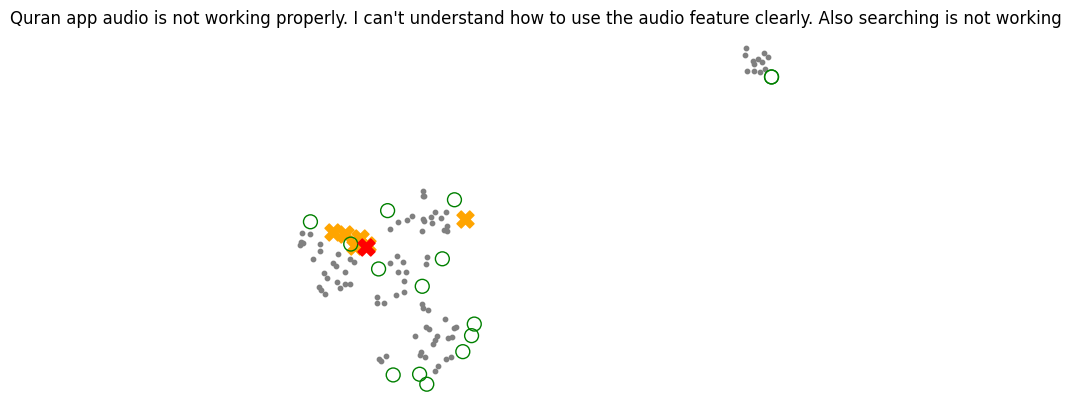

In [22]:
from helper_utils import project_embeddings, word_wrap
import umap

embeddings = chroma_db.get(include=["embeddings"])["embeddings"]
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

empbedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device=device)

# Visualize the results in the embedding space
original_query_embedding = empbedding_model.encode([original_query], convert_to_numpy=True, normalize_embeddings=True)
augmented_query_embeddings = empbedding_model.encode(joint_query, convert_to_numpy=True, normalize_embeddings=True)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)

retrieved_embeddings = dense_embeddings  # Assuming results["embeddings"] refers to dense_embeddings
projected_result_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(
    projected_dataset_embeddings[:, 0],
    projected_dataset_embeddings[:, 1],
    s=10,
    color="gray",
)
plt.scatter(
    project_augmented_queries[:, 0],
    project_augmented_queries[:, 1],
    s=150,
    marker="X",
    color="orange",
)
plt.scatter(
    projected_result_embeddings[:, 0],
    projected_result_embeddings[:, 1],
    s=100,
    facecolors="none",
    edgecolors="g",
)
plt.scatter(
    project_original_query[:, 0],
    project_original_query[:, 1],
    s=150,
    marker="X",
    color="r",
)

plt.gca().set_aspect("equal", "datalim")
plt.title(f"{original_query}")
plt.axis("off")
plt.show()

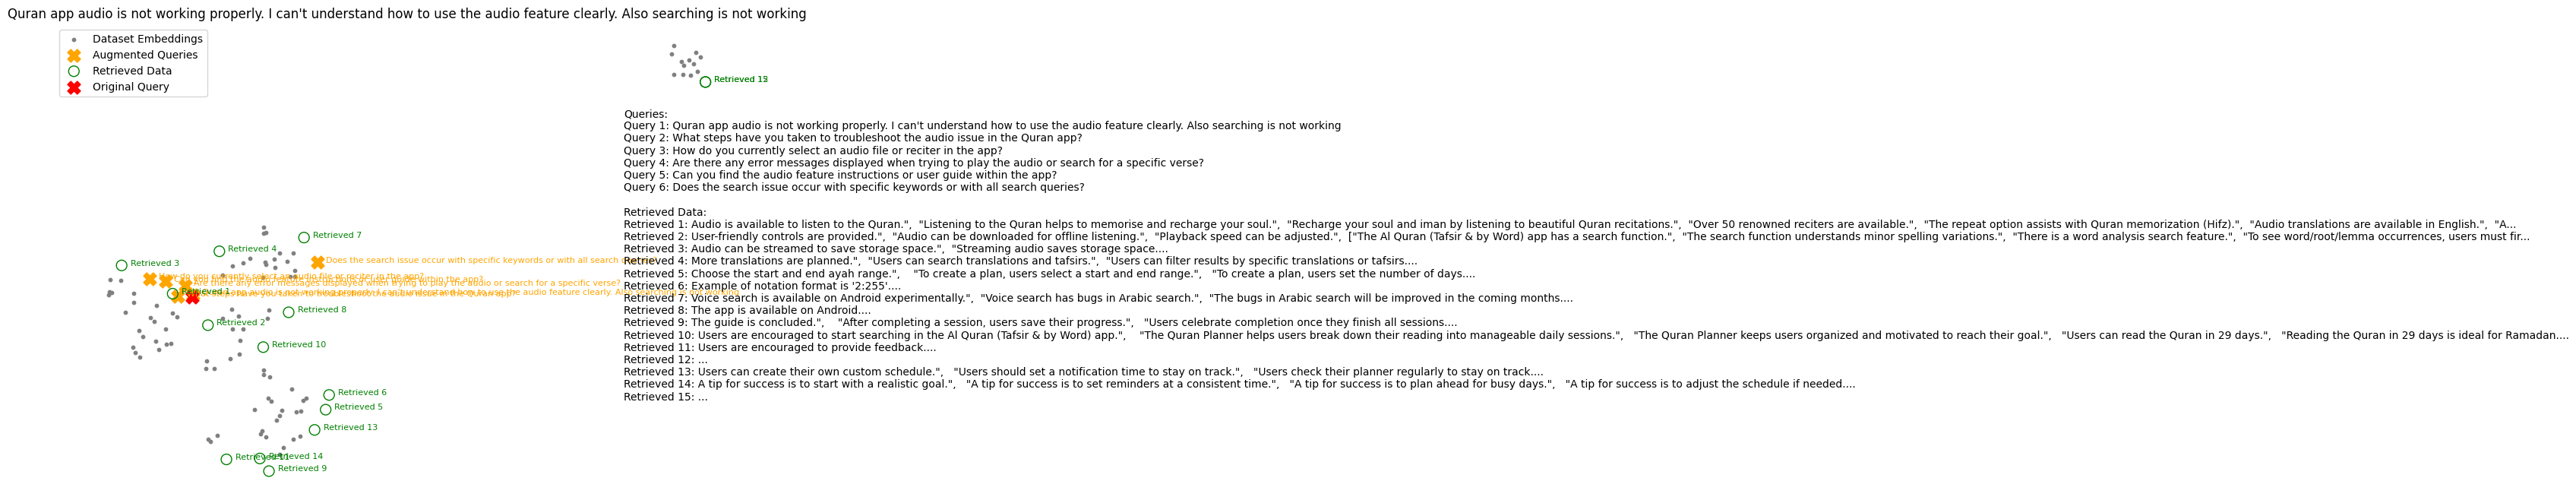

In [23]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure(figsize=(12, 8))
plt.scatter(
    projected_dataset_embeddings[:, 0],
    projected_dataset_embeddings[:, 1],
    s=10,
    color="gray",
    label="Dataset Embeddings",
)
plt.scatter(
    project_augmented_queries[:, 0],
    project_augmented_queries[:, 1],
    s=150,
    marker="X",
    color="orange",
    label="Augmented Queries",
)
plt.scatter(
    projected_result_embeddings[:, 0],
    projected_result_embeddings[:, 1],
    s=100,
    facecolors="none",
    edgecolors="g",
    label="Retrieved Data",
)
plt.scatter(
    project_original_query[:, 0],
    project_original_query[:, 1],
    s=150,
    marker="X",
    color="r",
    label="Original Query",
)

# Annotate the queries
for i, (x, y) in enumerate(project_augmented_queries):
    plt.text(x + 0.2, y, joint_query[i], fontsize=8, color="orange")

# Annotate the retrieved data
for i, (x, y) in enumerate(projected_result_embeddings):
    plt.text(x + 0.2, y, f"Retrieved {i+1}", fontsize=8, color="green")

# Add a legend
plt.legend(loc="upper left")

# Add a list of queries and retrieved data on the right side
query_text = "\n".join([f"Query {i+1}: {q}" for i, q in enumerate(joint_query)])
retrieved_text = "\n".join([f"Retrieved {i+1}: {doc.page_content[:350]}..." for i, doc in enumerate(documents)])

plt.gca().set_aspect("equal", "datalim")
plt.title(f"{original_query}")
plt.axis("off")

# Add text box for queries and retrieved data
plt.gcf().text(0.75, 0.5, f"Queries:\n{query_text}\n\nRetrieved Data:\n{retrieved_text}", fontsize=10, va="center", ha="left")

plt.show()